GIF saved as 3d_box_transformation_with_orientation_trail.gif


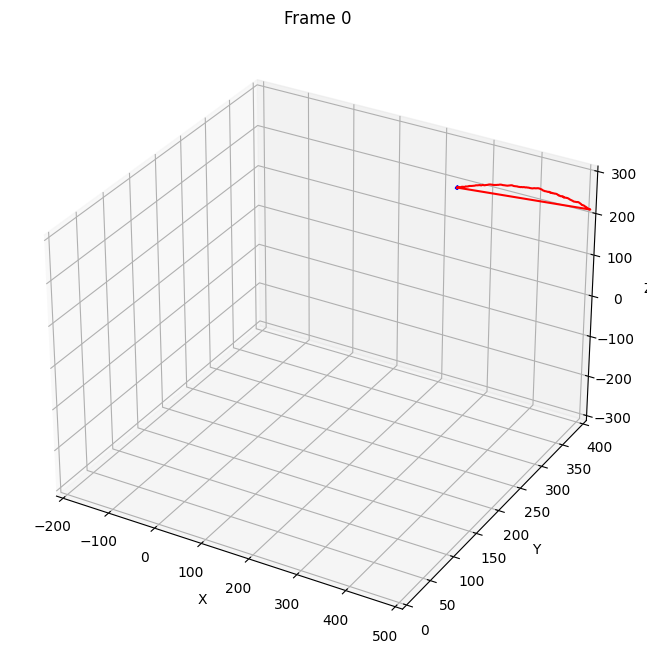

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
from matplotlib.animation import FuncAnimation, PillowWriter

def rotation_matrix_to_euler_angles(matrix):
    """
    Convert a rotation matrix to Euler angles (yaw, pitch, roll) in degrees.
    The function assumes the rotation matrix follows the convention ZYX.
    """
    sy = np.sqrt(matrix[0, 0] ** 2 + matrix[1, 0] ** 2)
    singular = sy < 1e-6

    if not singular:
        yaw = np.arctan2(matrix[1, 0], matrix[0, 0])
        pitch = np.arctan2(-matrix[2, 0], sy)
        roll = np.arctan2(matrix[2, 1], matrix[2, 2])
    else:
        yaw = np.arctan2(-matrix[1, 2], matrix[1, 1])
        pitch = np.arctan2(-matrix[2, 0], sy)
        roll = 0

    return np.degrees([yaw, pitch, roll])

def apply_transformation(points, rotation_matrix, translation_vector):
    """
    Apply a transformation to the given points by rotating first, then translating.
    """
    # Rotate points first
    rotated_points = points @ rotation_matrix.T
    # Then translate
    transformed_points = rotated_points + translation_vector
    return transformed_points

def parse_transformations(filename):
    """
    Parses transformation matrices from the file, separates rotation and translation components.
    Returns a list of (rotation_matrix, translation_vector) tuples.
    """
    matrices = []
    pattern = re.compile(r'Seq_Frame\d+_ProbeToTrackerTransform = ([\d\.\-\s]+)')
    
    with open(filename, 'r') as file:
        content = file.read()
        matches = pattern.findall(content)
        
        for match in matches:
            values = list(map(float, match.split()))
            # Rotation part (3x3)
            rotation_matrix = np.array([
                [values[0], values[1], values[2]],
                [values[4], values[5], values[6]],
                [values[8], values[9], values[10]]
            ])
            # Translation part
            translation_vector = np.array([values[3], values[7], values[11]])
            matrices.append((rotation_matrix, translation_vector))
    return matrices

def create_box():
    return np.array([
        [-1, -1, -1], [1, -1, -1], [1, 1, -1], [-1, 1, -1],
        [-1, -1, 1], [1, -1, 1], [1, 1, 1], [-1, 1, 1]
    ])

# Load transformations
filename = 'Inputforrecon_mha_transformsOnly_Group3.txt'
transform_matrices = parse_transformations(filename)
box_points = create_box()

# Prepare the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-200, 500])
ax.set_ylim([0, 400])
ax.set_zlim([-300, 300])

trail_points = []

def update(frame):
    ax.clear()
    rotation_matrix, translation_vector = transform_matrices[frame]
    transformed_box = apply_transformation(box_points, rotation_matrix, translation_vector)
    
    box_center = np.mean(transformed_box, axis=0)
    trail_points.append(box_center)
    
    for i in range(4):
        ax.plot([transformed_box[i][0], transformed_box[(i+1)%4][0]], 
                [transformed_box[i][1], transformed_box[(i+1)%4][1]], 
                [transformed_box[i][2], transformed_box[(i+1)%4][2]], 'b-')
        
        ax.plot([transformed_box[i+4][0], transformed_box[(i+1)%4 + 4][0]], 
                [transformed_box[i+4][1], transformed_box[(i+1)%4 + 4][1]], 
                [transformed_box[i+4][2], transformed_box[(i+1)%4 + 4][2]], 'b-')
        
        ax.plot([transformed_box[i][0], transformed_box[i+4][0]], 
                [transformed_box[i][1], transformed_box[i+4][1]], 
                [transformed_box[i][2], transformed_box[i+4][2]], 'b-')
    
    trail_points_array = np.array(trail_points)
    ax.plot(trail_points_array[:, 0], trail_points_array[:, 1], trail_points_array[:, 2], 'r-')
    
    # Extract rotation matrix and compute Euler angles
    yaw, pitch, roll = rotation_matrix_to_euler_angles(rotation_matrix)
    
    #ax.quiver(box_center[0], box_center[1], box_center[2], yaw, pitch, roll, color="g", length=50)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Frame {frame}')
    
    ax.set_xlim([-200, 500])
    ax.set_ylim([0, 400])
    ax.set_zlim([-300, 300])

anim = FuncAnimation(fig, update, frames=len(transform_matrices), interval=200)
gif_filename = '3d_box_transformation_with_orientation_trail.gif'
writer = PillowWriter(fps=10)
anim.save(gif_filename, writer=writer)

print(f"GIF saved as {gif_filename}")
